In [1]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from matplotlib import pyplot as plt

In [2]:
# Generate training set array
PATH = "/home/fizzer/353_comp_training/training_data2"
labels_raw = !ls "{PATH}"
labels = [ labels.split() for labels in labels_raw]
labels = labels[1::]

label_list = []
raw_images = []
for label in labels:
  for path in label:
    label_list.append(path) 

for label in label_list:
  img = cv2.imread(f"/home/fizzer/353_comp_training/training_data2/{label}")
  raw_images.append(np.array(img))

#raw_images = [np.array(cv2.imread(f"/home/fizzer/353_comp_training/training_data/{label}")) for label in label_list]
print(len(raw_images))


2822


In [3]:
!CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib
!env | grep LD_LIBRARY_PATH

/bin/bash: /home/fizzer/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/fizzer/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/fizzer/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
LD_LIBRARY_PATH=/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/home/fizzer/ros_ws/devel/lib:/opt/ros/noetic/lib:/home/fizzer/miniconda3/envs/tf/lib/:/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/fizzer/miniconda3/envs/tf/lib/:/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/fizzer/miniconda3/envs/tf/lib/:/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib


In [4]:
import tensorflow as tf


In [5]:
print(label_list)
label_list_2 = []
for label in label_list:
  timestamped = (label.split('.p')[0]).split(',')
  label_list_2.append(timestamped[0]+ ',' + timestamped[1])

print((label_list_2))
print(len(raw_images))

['-0.001,0.057,1701.823.png', '-0.001,0.059,1730.691.png', '-0.001,0.061,1593.091.png', '-0.001,0.069,1567.026.png', '-0.001,0.095,1513.09.png', '0.001,0.219,1545.225.png', '0.001,0.22,1498.896.png', '-0.001,0.22,1499.025.png', '-0.001,0.22,1526.825.png', '-0.001,0.222,1610.892.png', '0.001,0.223,1498.358.png', '0.001,0.223,1498.903.png', '0.001,0.223,1526.426.png', '0.001,0.223,1687.692.png', '-0.001,0.224,1552.628.png', '-0.001,0.225,1526.025.png', '-0.001,0.225,1552.093.png', '-0.001,0.225,1637.959.png', '-0.001,0.225,1639.161.png', '0.001,0.225,1686.893.png', '-0.001,0.225,1687.491.png', '0.001,0.226,1606.758.png', '0.001,0.226,1610.692.png', '-0.001,0.227,1497.692.png', '0.001,0.227,1545.094.png', '-0.001,0.227,1552.495.png', '-0.001,0.227,1552.695.png', '-0.001,0.227,1687.425.png', '-0.001,0.228,1527.359.png', '0.001,0.228,1610.624.png', '0.001,0.228,1715.759.png', '-0.001,0.229,1552.428.png', '-0.001,0.229,1581.892.png', '-0.001,0.229,1641.424.png', '0.001,0.229,1686.224.png', '

In [6]:
# generate dataset
# onehot encode 3 different actions: turn left, turn right, go straight
dataset = []
encoding  = []
#4 different options, left right forward stop in that order
for image, label in zip(raw_images, label_list):
  pose = label.split(',')
  twist = float(pose[0])
  x = float(pose[1])
  if abs(twist) > 0.01 and twist > 0:
    encoding.append(np.eye(4)[0])
  elif abs(twist) > 0.01 and twist < 0:
    encoding.append(np.eye(4)[1])
  elif x > 0.1:
    encoding.append(np.eye(4)[2])
  else:
    encoding.append(np.eye(4)[3])
  dataset.append(image)

x = np.array(dataset)
y = np.array(encoding)

In [7]:
import math

from numpy.matrixlib.defmatrix import N
VALIDATION_SPLIT = 0.2

split_index = math.ceil(x.shape[0] * (1-VALIDATION_SPLIT))
# randomize the order of the two datasets
shuffler = np.random.permutation(len(x))
x = x[shuffler]
y = y[shuffler]

X_train_dataset = x[:split_index]
Y_train_dataset = y[:split_index]

X_val_dataset = x[split_index:]
Y_val_dataset = y[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(x.shape))
print("Y shape: " + str(y.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(x.shape[0],
             X_train_dataset.shape[0],
              X_val_dataset.shape[0]))

X shape: (2822, 90, 160, 3)
Y shape: (2822, 4)
Total examples: 2822
Training examples: 2258
Validation examples: 564


In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [9]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [10]:
## create the model
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu',
                             input_shape=(90, 160, 3)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(256, activation='relu'))
conv_model.add(layers.Dense(128, activation='relu'))
conv_model.add(layers.Dense(4, activation='softmax'))

2023-04-13 10:39:13.338263: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='binary_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [12]:
reset_weights(conv_model)

In [13]:
history_conv = conv_model.fit(X_train_dataset, Y_train_dataset, 
                              validation_data=(X_val_dataset, Y_val_dataset), 
                              epochs=10, 
                              batch_size=256)

2023-04-13 10:39:15.238549: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 97545600 exceeds 10% of free system memory.


Epoch 1/10


2023-04-13 10:39:20.795102: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 44236800 exceeds 10% of free system memory.
2023-04-13 10:39:20.842487: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 911212544 exceeds 10% of free system memory.
2023-04-13 10:39:22.177633: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 227803136 exceeds 10% of free system memory.
2023-04-13 10:39:22.582589: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 105971712 exceeds 10% of free system memory.


: 

: 

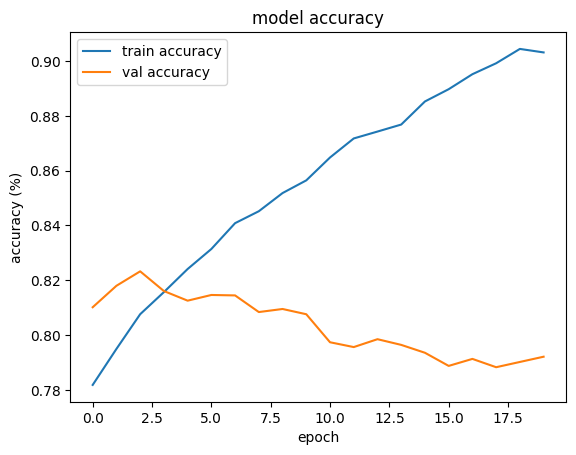

In [ ]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [ ]:
conv_model.save("/home/fizzer/ros_ws/src/Enph353-Compition-Controller/src/new_model")

INFO:tensorflow:Assets written to: /home/fizzer/ros_ws/src/Enph353-Compition-Controller/src/new_model/assets
